# Imports & get data

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [3]:
import os
import pickle
from tqdm import tqdm
from copy import deepcopy

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

In [5]:
with open('../fea_notebooks/features_with_mae_encdec.pickle', 'rb') as handle:
    data=pickle.load(handle)
print(len(data))

861563


In [6]:
print(f"Torch: {torch.__version__}")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

Torch: 2.0.1+cu117
cuda:0


# Expression Recognition Challenge
## Get target data

In [7]:
idx_to_class_2={0: 'Neutral', 1:'Anger', 2:'Disgust', 3:'Fear', 
                4:'Happiness', 5:'Sadness', 6:'Surprise', 7:'Other'} #ABAW
classes = ['Neutral', 'Anger', 'Disgust', 'Fear', 
           'Happiness', 'Sadness', 'Surprise', 'Other']

In [8]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations'

def get_image2Expr(dirname):
    dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/',dirname)
    num_missed=[]
    targets = {}
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                prev_val=None
                for i,line in enumerate(lines):
                    if i>0:
                        expression=int(line)
                        if expression>=0:
                            imagename=fn+'/'+str(i).zfill(5)+'.jpg'
                            if imagename in data:
                                targets[imagename] = expression
                            else:
                                num_missed.append(imagename)
    print(len(targets), len(num_missed))
    return targets, num_missed

y_train, num_missed_train = get_image2Expr('Train_Set')
y_val, num_missed_test =get_image2Expr('Validation_Set')

586959 10402
279749 4481


## Get train samples

In [9]:
experiment = Experiment(
  api_key="XhQqrLR91F7zW3AZ7LgVT3zp2",
  project_name="abaw6",
  workspace="annanet"
)

experiment.set_name('expr-tcn_attention+linear(emoti+mae_encdec)')
experiment.add_tags(['expr_classif_tcn - tcn_attention+linear', 'v2_tcn+linear'])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/hse_student/apsidorova/main notebooks' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annanet/abaw6/202302f303e64a258c47d9f48e0cc93f



In [10]:
def train_val_split(y_train, y_val):
    w2v2large_t, openl3_t, w2v2hub_t, y_t = \
    [], [], [], []
    X_t, x_t, X_v, x_v = [], [], [], []
    for key in y_train.keys():
        X_t.append(data[key]['frame'][0])
        x_t.append(data[key]['mae'])
        w2v2large_t.append(data[key]['w2v2large'])
        openl3_t.append(data[key]['openl3'])
        w2v2hub_t.append(data[key]['w2v2hub'])
        y_t.append(y_train[key])

    w2v2large_v, openl3_v, w2v2hub_v, y_v = \
    [], [], [], []
    
    for key in y_val.keys():
        X_v.append(data[key]['frame'][0])
        x_v.append(data[key]['mae'])
        w2v2large_v.append(data[key]['w2v2large'])
        openl3_v.append(data[key]['openl3'])
        w2v2hub_v.append(data[key]['w2v2hub'])
        y_v.append(y_val[key])

    print(len(X_t), len(w2v2large_t), len(openl3_t), len(w2v2hub_t), len(y_t), len(x_t),
          len(X_v), len(w2v2large_v), len(openl3_v), len(w2v2hub_v), len(y_v), len(x_v))
    
    return (np.array(X_t),np.array(w2v2large_t), 
            np.array(openl3_t), np.array(w2v2hub_t), 
            np.array(y_t),
            np.array(x_t),
            np.array(X_v), np.array(w2v2large_v), 
            np.array(openl3_v), np.array(w2v2hub_v), 
            np.array(y_v),
            np.array(x_v))

X_t, w2v2large_t, openl3_t, w2v2hub_t, y_t, x_t,\
X_v, w2v2large_v, openl3_v, w2v2hub_v, y_v, x_v = train_val_split(y_train, y_val)

586959 586959 586959 586959 586959 586959 279749 279749 279749 279749 279749 279749


In [11]:
from math import ceil


class audioDataset(Dataset):
    def __init__(self, names, values, y, window=300, step=200):
        self.data = values
        self.lenghts_of_seq = len(self.data[0])
        self.y = y
        
        self.names = names
        self.window = window
        self.step = step
        
        self.len = ceil((self.lenghts_of_seq - self.window) / self.step) + 1
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if idx == self.len-1:
            stride = [torch.Tensor(i[-self.window::]) for i in self.data]
            y = self.y[-self.window::]
        
        else:
            stride = [torch.Tensor(i[idx*self.step:idx*self.step + self.window]) for i in self.data]
            y = self.y[idx*self.step:idx*self.step + self.window]
            
        r_dict = dict([(i, j.to(device)) for i, j in zip(self.names, stride)])
        
        return r_dict, y

In [12]:
taudio = audioDataset(['frames', 'mae', 'w2v2large', 'openl3', 'w2v2hub'],
                     [X_t, x_t, w2v2large_t, openl3_t, w2v2hub_t], y_t)
training_loader = DataLoader(taudio, batch_size=64, shuffle=False)

In [15]:
vaudio = audioDataset(['frames', 'mae', 'w2v2large', 'openl3', 'w2v2hub'],
                     [X_v, x_v, w2v2large_v, openl3_v, w2v2hub_v], y_v,
                     window=300, step=300)
validation_loader = DataLoader(vaudio, batch_size=64, shuffle=False)
len(vaudio), len(validation_loader)

(933, 15)

## TCN

In [17]:
(unique, counts) = np.unique(y_t, return_counts=True)
num_classes=len(unique)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, num_classes, unique)
print()
print(np.unique(y_v, return_counts=True))

[177498  16573  10810   9080  95633  79862  31637 165866] {0: 1.0, 1: 10.710070596753756, 2: 16.419796484736356, 3: 19.548237885462555, 4: 1.8560329593341212, 5: 2.2225589141268687, 6: 5.610456111514998, 7: 1.0701288992319102} 8 [0 1 2 3 4 5 6 7]

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 82219,   6126,   4899,   8408,  34348,  25091,  12214, 106444]))


In [18]:
from tcn.tcn import TemporalConvNet
from tcn.trans_encoder import TransEncoder


class Model(nn.Module):
    def __init__(self, modality=['frames', 'mae', 'w2v2large', 'openl3', 'w2v2hub'],
                 embedding_dim={'frames': 1280, 'mae': 1280, 'w2v2large': 1024, 'openl3': 512,
                                'w2v2hub': 256},
                 tcn_channel={
                     'frames': [1280, 512, 256, 128],
                     'mae': [1280, 512, 256, 128],
                     'w2v2large': [1024, 512, 256, 128],
                     'openl3': [512, 256, 128],
                     'w2v2hub': [256, 128]
    }):
        super(Model, self).__init__()
        self.modality = modality

        self.temporal, self.fusion = nn.ModuleDict(), None

        for modal in self.modality:
            self.temporal[modal] = TemporalConvNet(num_inputs=embedding_dim[modal],
                                                   num_channels=tcn_channel[modal], dropout=0.3, attention=False)

        conv_dim = 0
        for m in self.modality:
            conv_dim += tcn_channel[m][-1]
            
        self.encoder = TransEncoder(
            inc=conv_dim, outc=256, dropout=0.3, nheads=4, 
            nlayer=8)
            
        self.head = nn.Sequential(
            nn.Linear(256, 256//2),
            nn.BatchNorm1d(256//2),
            nn.Linear(256//2, 8),
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        bs, seq_len, _ = x[self.modality[0]].shape
#         print(bs, seq_len)
        for m in self.modality:
            x[m] = x[m].transpose(1, 2)
#             print(f'{m} shape start', x[m].shape)
            x[m] = self.temporal[m](x[m])
#             print(f'{m} shape end', x[m].shape)
#             print()

        feat_list = []
        for m in self.modality:
            feat_list.append(x[m])
        out = torch.cat(feat_list, dim=1)
        out = self.encoder(out)

        out = torch.transpose(out, 1, 0)
        out = torch.reshape(out, (bs*seq_len, -1))
#         print(out.shape)

        out = self.head(out)
        return self.softmax(out)

model = Model()
model.to(device);

## Train

In [19]:
hyperparams = {
    'epochs': 300,
    'loss': 'categorical_crossentropy',
    'lr': 1e-4,
    'batch': 64
}

In [23]:
experiment.log_parameters(hyperparams)
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(cw)).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-6)

best_model_params = deepcopy(model.state_dict())

best_vloss = 0

In [32]:
model.eval()
for i, tdata in enumerate(training_loader):
    inputs, labels = tdata
    labels = labels.reshape(-1).to(device)

    outputs = model(inputs)
    break

frames shape start torch.Size([64, 1280, 300])
frames shape end torch.Size([64, 128, 300])

mae shape start torch.Size([64, 1280, 300])
mae shape end torch.Size([64, 128, 300])

w2v2large shape start torch.Size([64, 1024, 300])
w2v2large shape end torch.Size([64, 128, 300])

openl3 shape start torch.Size([64, 512, 300])
openl3 shape end torch.Size([64, 128, 300])

w2v2hub shape start torch.Size([64, 256, 300])
w2v2hub shape end torch.Size([64, 128, 300])



In [ ]:
for epoch in range(hyperparams['epochs']):
    print('EPOCH {}:'.format(epoch + 1))
    pred_labels_train, pred_labels_val = [], []
    labels_train, labels_val = [], []

    model.train(True)
    
    running_loss = 0.
    last_loss = 0.

    for i, tdata in enumerate(training_loader):
        inputs, labels = tdata
        labels = labels.reshape(-1).to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        pred_labels_train += predicted.tolist()
        labels_train += labels.tolist()
    
    avg_loss = running_loss / i + 1
    experiment.log_metric('loss_train', avg_loss, 
                          epoch=epoch)
    
    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vlabels = vlabels.reshape(-1).to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            
            _, predicted = torch.max(voutputs.data, 1)
            pred_labels_val += predicted.tolist()
            labels_val += vlabels.tolist()

    avg_vloss = running_vloss / (i + 1)
    val_f1 = f1_score(labels_val,
                      pred_labels_val,
                      average='macro')
    print('LOSS train {} valid {}, f1_valid {}'.format(avg_loss, avg_vloss, val_f1))
    experiment.log_metric('loss_val', avg_vloss, 
                          epoch=epoch)
    experiment.log_metric('f1_val', f1_score(labels_val,
                                             pred_labels_val,
                                             average='macro'), 
                          epoch=epoch)
    experiment.log_metric('f1_train', f1_score(labels_train,
                                               pred_labels_train,
                                               average='macro'), 
                          epoch=epoch)
    
    if val_f1 > best_vloss:
        best_vloss = val_f1
        best_model_params = deepcopy(model.state_dict())

## Test

In [26]:
model.load_state_dict(best_model_params)
pred_labels_val, labels_val = [], []

model.eval()
with torch.no_grad():
    for i, vdata in enumerate(tqdm(validation_loader)):
        vinputs, vlabels = vdata
        vlabels = vlabels.reshape(-1).to(device)
        voutputs = model(vinputs)

        _, predicted = torch.max(voutputs.data, 1)
        pred_labels_val += predicted.tolist()
        labels_val += vlabels.tolist()

100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


In [27]:
f1 = f1_score(labels_val,
        pred_labels_val,
        average='macro')

In [29]:
(np.array(labels_val)==np.array(pred_labels_val)).mean()

0.4358127902822437

In [30]:
f1

0.2813374799777542

In [31]:
experiment.log_confusion_matrix(
    np.array(labels_val),np.array(pred_labels_val),
    title="Confusion Matrix: Evaluation",
    file_name="confusion-matrix-eval.json",
)

{'web': 'https://www.comet.com/api/asset/download?assetId=a8229a44fbc9417683c4add09c187b3a&experimentKey=202302f303e64a258c47d9f48e0cc93f',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=a8229a44fbc9417683c4add09c187b3a&experimentKey=202302f303e64a258c47d9f48e0cc93f',
 'assetId': 'a8229a44fbc9417683c4add09c187b3a'}

(279900,) (279900,) 0.4358127902822437


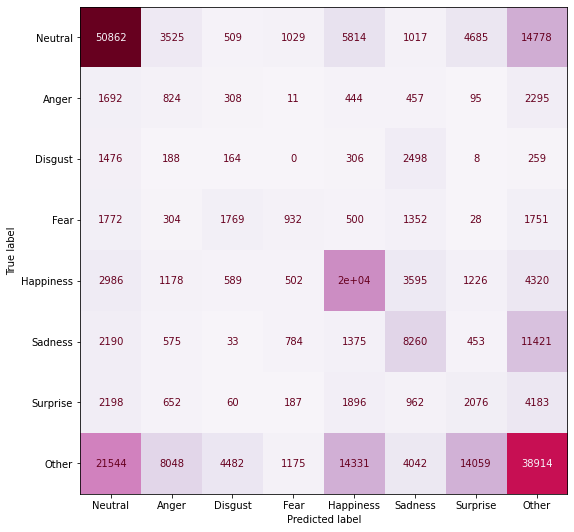

In [32]:
labels=classes
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='PuRd', colorbar=False)
    plt.tight_layout()
    plt.show()

plt_conf_matrix(np.array(labels_val),np.array(pred_labels_val),labels);

In [33]:
torch.save(model.state_dict(), 'mae+emoti+tcn_encdec.pt')
experiment.log_model("mae+emoti+tcn_encdec.pt", file_or_folder="mae+emoti+tcn_encdec.pt")

{'web': 'https://www.comet.com/api/asset/download?assetId=349dc56e9d43482ab0c0447213b538d7&experimentKey=202302f303e64a258c47d9f48e0cc93f',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=349dc56e9d43482ab0c0447213b538d7&experimentKey=202302f303e64a258c47d9f48e0cc93f',
 'assetId': '349dc56e9d43482ab0c0447213b538d7'}

In [34]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annanet/abaw6/202302f303e64a258c47d9f48e0cc93f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     f1_train [315]   : (0.16776927770410027, 0.8193780815423681)
COMET INFO:     f1_val [315]     : (0.08753548113165169, 0.2813374799777542)
COMET INFO:     loss [1451]      : (1.283884048461914, 2.162038803100586)
COMET INFO:     loss_train [315] : (2.4316367069880167, 3.089959059821235)
COMET INFO:     loss_val [315]   : (1.9344576597213745, 2.101832151412964)
COMET INFO:   Others:
COMET INFO:     Name : expr-tcn_attention+linear(emoti+mae_encdec)
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix    : 1
COMET INFO:     e